In [1]:
import tensorflow as tf
import keras
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import os
from PIL import Image

In [2]:
dir = './Aadhar Pan Images/train/'

In [3]:
files = list(os.walk(dir))[0][2]

In [4]:
images = []

for img in files:

    images.append(np.array(Image.open(dir+img)))

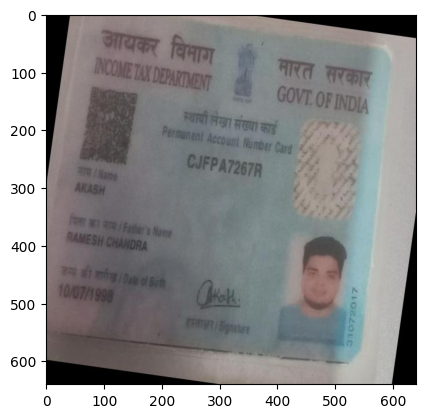

In [5]:
plt.imshow(images[10])

In [6]:
y = np.array([cv.resize(img,(128,128)) for img in images])
X = np.array([cv.resize(img,(64,64)) for img in images])

In [7]:
y = np.array(y)/255
X = np.array(X)/255

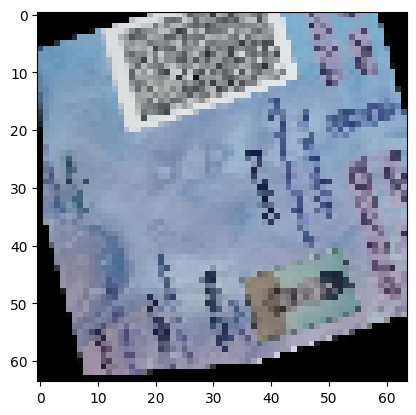

In [8]:
plt.imshow(X[20])

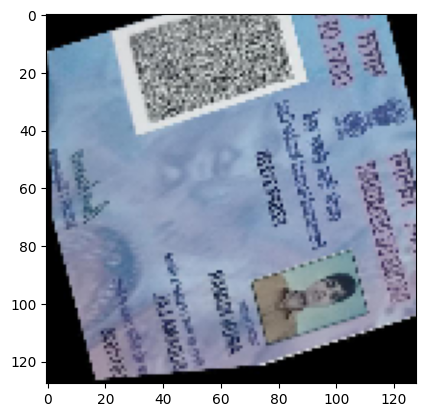

In [9]:
plt.imshow(y[20])

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

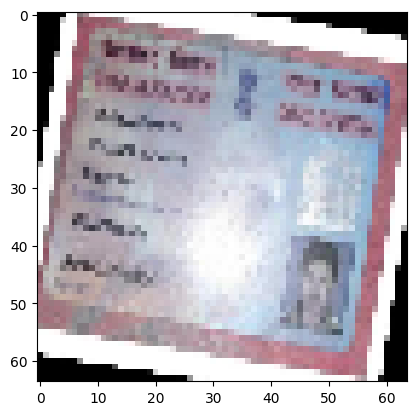

In [12]:
plt.imshow(X_train[10])

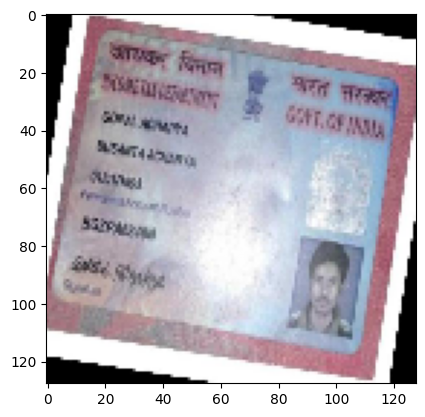

In [13]:
plt.imshow(Y_train[10])

In [14]:
X_train.shape, Y_train.shape

((3044, 64, 64, 3), (3044, 128, 128, 3))

In [15]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [16]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
def residual_block_gen(ch=32,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
    ])
    return model

def Upsample_block(x, ch=64, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st),padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def get_enhancer():
        
    input_lr=tf.keras.layers.Input(shape=(64,64,3))
    input_conv=tf.keras.layers.Conv2D(32,5,padding='same')(input_lr)
    input_conv=tf.keras.layers.LeakyReLU()(input_conv)
    SRRes=input_conv
    
    for x in range(4):
        res_output=residual_block_gen()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(32,5,padding='same')(SRRes)
        SRRes=tf.keras.layers.BatchNormalization()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,input_conv])
        
    SRRes=Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,5,activation='tanh',padding='same')(SRRes)

    return tf.keras.Model(input_lr,output_sr)

In [38]:
inputs = layers.Input(shape=(64,64,3))
outputs = get_enhancer()(inputs)
model = keras.Model(inputs,outputs)

In [39]:
model.compile(optimizer='Adam',loss='mse',metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model_2 (Functional)        (None, 128, 128, 3)       162163    
                                                                 
Total params: 162,163
Trainable params: 161,907
Non-trainable params: 256
_________________________________________________________________


In [ ]:
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=30,batch_size=32)

Epoch 1/30
96/96 [==============================] - 7s 65ms/step - loss: 0.0628 - accuracy: 0.3741 - val_loss: 0.0424 - val_accuracy: 0.3540
Epoch 2/30
96/96 [==============================] - 6s 60ms/step - loss: 0.0146 - accuracy: 0.5286 - val_loss: 0.0174 - val_accuracy: 0.3770
Epoch 3/30
96/96 [==============================] - 6s 60ms/step - loss: 0.0124 - accuracy: 0.5694 - val_loss: 0.0171 - val_accuracy: 0.5806
Epoch 4/30
96/96 [==============================] - 6s 61ms/step - loss: 0.0114 - accuracy: 0.6010 - val_loss: 0.0147 - val_accuracy: 0.6003
Epoch 5/30
96/96 [==============================] - 6s 61ms/step - loss: 0.0110 - accuracy: 0.6214 - val_loss: 0.0164 - val_accuracy: 0.6363
Epoch 6/30
96/96 [==============================] - 6s 61ms/step - loss: 0.0107 - accuracy: 0.6408 - val_loss: 0.0116 - val_accuracy: 0.5596
Epoch 7/30
96/96 [==============================] - 6s 61ms/step - loss: 0.0103 - accuracy: 0.6546 - val_loss: 0.0125 - val_accuracy: 0.6881
Epoch 8/30
96

In [27]:
mean=0
sigma = 0
n = np.random.normal(loc=mean,scale=sigma,size=(64,64,3))
x_test = np.array([img for img in X[:10]])
y_test = np.array([img for img in y[:10]])

In [28]:
preds = model.predict(np.array(x_test))

1/1 [==============================] - 0s 17ms/step


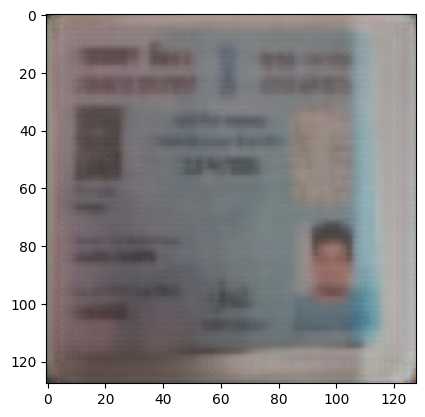

In [29]:
plt.imshow(preds[9])

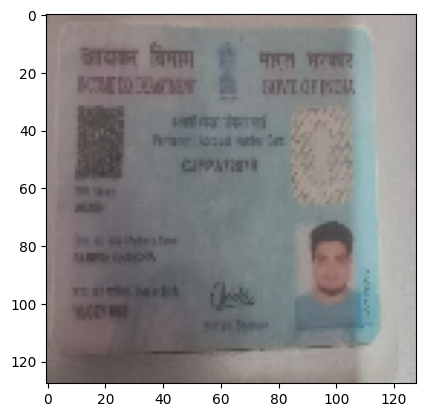

In [34]:
plt.imshow(y_test[9])